In [3]:
import numpy as np
import pandas as pd
#%matplotlib inline
import re
import os
import math
import numpy as np
import pandas as pd
import joblib
import warnings
import time
import matplotlib.pyplot as plt

# Importamos nuestras funciones
import sys
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, Birch
from sklearn.decomposition import PCA


data_sonda_2023_Matlab = pd.read_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_sonda_2023_preprocesadoMatlab.csv', index_col=[0,1,2,3,4,5,6,7])
data_sonda_2024_Matlab = pd.read_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_sonda_2024_preprocesadoMatlab.csv', index_col=[0,1,2,3,4,5,6,7])

# Comparación medidas preprocesadas por Matlab de la sonda en 2023 - 2024

In [4]:
muestras = data_sonda_2024_Matlab.index.get_level_values('Muestra').unique().tolist()
# muestras.remove('LIT7')
# muestras.remove('LIT921.1')
muestras_ordenadas = ['LIT1', 'LIT2', 'LIT3', 'LIT4','LIT5','LIT6','LIT235.3', 'LIT885.1']
def SNV(input_data):
    """
    Procesado de datos: SNV (Standard Normal Variate).
    1) Media de cada channel --> axis=1 (todas las columnas).
    2) Se le resta su media a cada "channel" --> axis=0 (todas las filas).
    3) Divide cada channel por su StDev --> axis=1 (todas las columnas).
    :parameter *input_data*: matriz de datos, en formato: "channels(f) x time(c)".
    :return: matriz de datos, una vez normalizados
    """
    data_12 = input_data.sub(input_data.mean(axis=1), axis=0)
    data_snv = data_12.div(input_data.std(axis=1), axis=0)
    return data_snv

data_sonda_2023_Matlab_snv = SNV(data_sonda_2023_Matlab)
data_sonda_2024_Matlab_snv = SNV(data_sonda_2024_Matlab)    

Espectros medios para las muestras normalizados con SNV


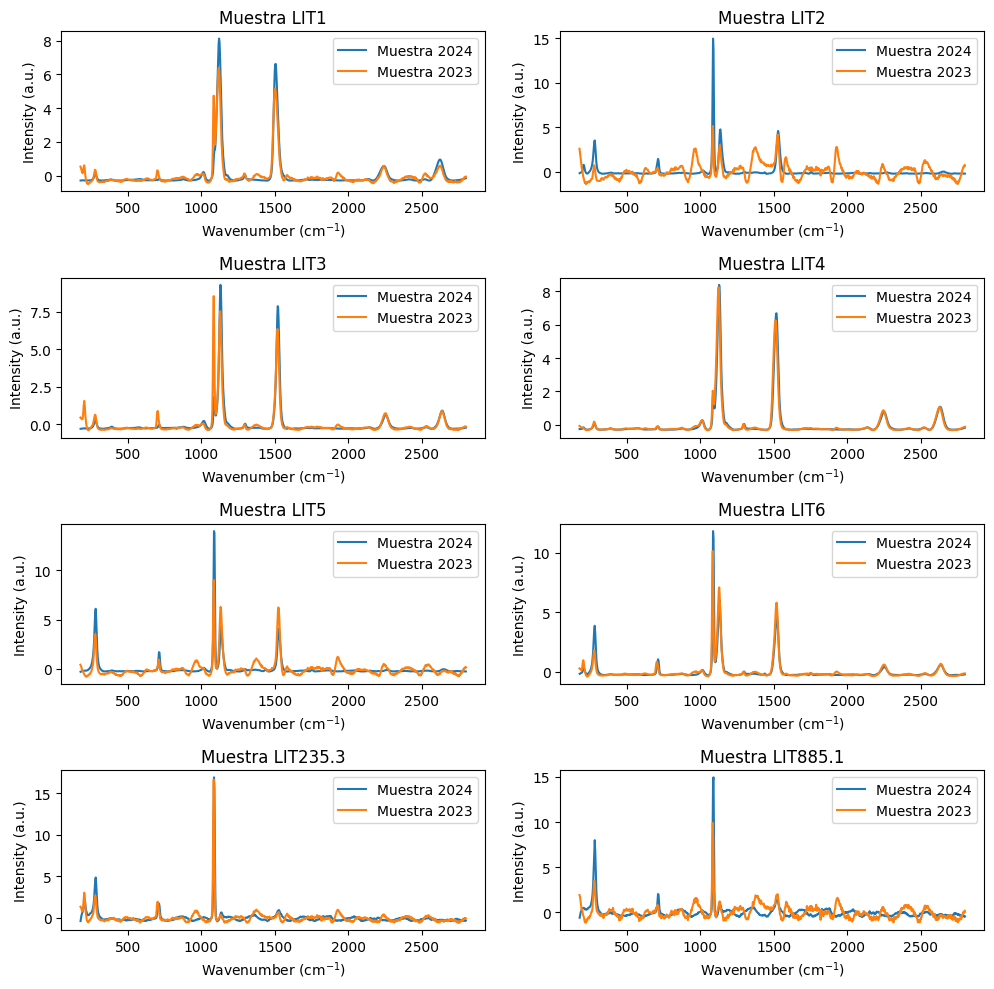

Espectros medios para las muestras sin normalizar


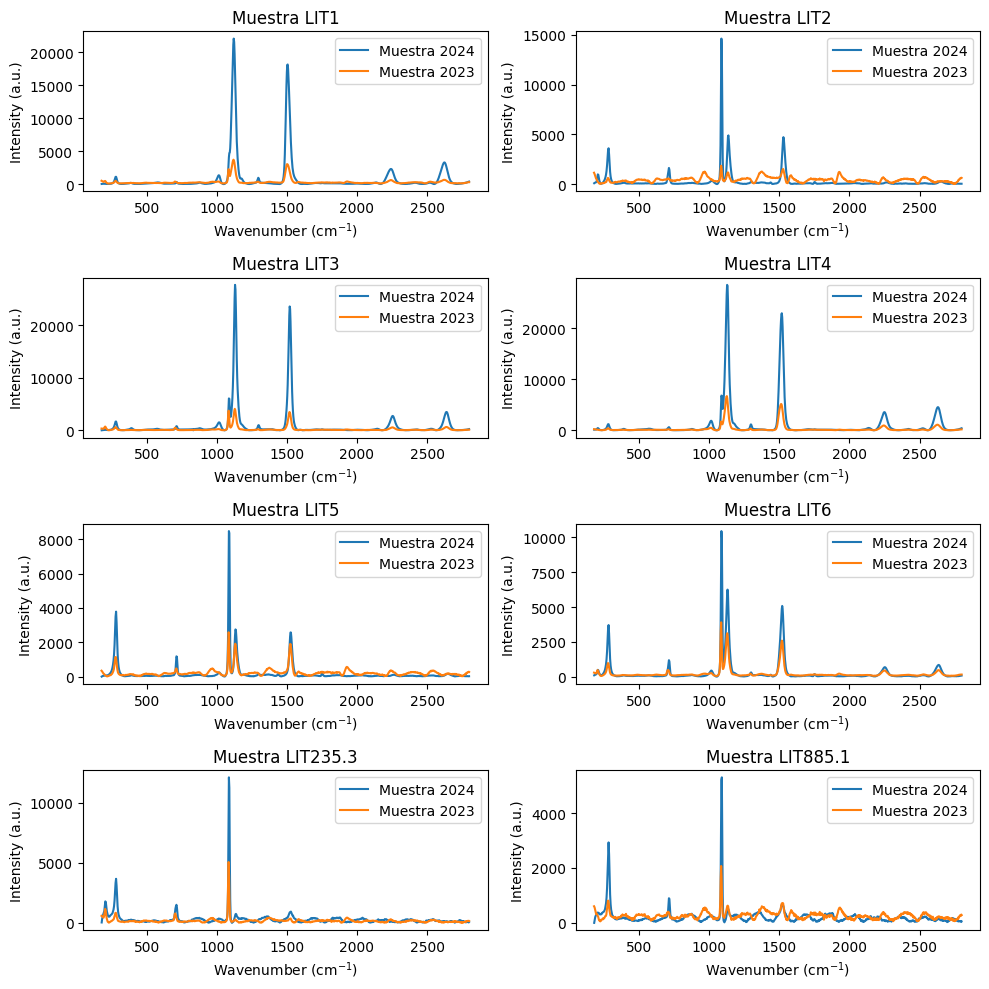

In [51]:
def avg_spectrum_all_8muestras_comp(data1, data2, muestras):

    fig, axes = plt.subplots(4, 2, figsize=(10, 10))

    # Itera sobre las muestras y representa cada una en su subplot
    for i, muestra in enumerate(muestras):
        # Datos para 2023
        data_muestra1 = data1[data1.index.get_level_values('Muestra') == f'{muestra}']
        wavenumber1 = data_muestra1.columns.get_level_values(0).astype(float)
        mean_intensity1 = data_muestra1.mean(axis=0)

        # Datos para 2024
        data_muestra2 = data2[data2.index.get_level_values('Muestra') == f'{muestra}']
        wavenumber2 = data_muestra2.columns.get_level_values(0).astype(float)
        mean_intensity2 = data_muestra2.mean(axis=0)

        # Calcula la posición del subplot en la matriz de subplots
        fila = i // 2
        columna = i % 2

        # Representa el espectro medio en el subplot correspondiente
        axes[fila, columna].plot(wavenumber2, mean_intensity2, label=f'Muestra 2024')
        axes[fila, columna].plot(wavenumber1, mean_intensity1, label=f'Muestra 2023')
        
        axes[fila, columna].set_xlabel('Wavenumber (cm$^{-1}$)')
        axes[fila, columna].set_ylabel('Intensity (a.u.)')
        axes[fila, columna].set_title(f'Muestra {muestra}')

        axes[fila, columna].legend()

    # Ajusta el espaciado entre subplots
    plt.tight_layout()

    # Muestra los subplots
    plt.show()

print('Espectros medios para las muestras normalizados con SNV')
avg_spectrum_all_8muestras_comp(data_sonda_2023_Matlab_snv, data_sonda_2024_Matlab_snv, muestras_ordenadas)
print('Espectros medios para las muestras sin normalizar')
avg_spectrum_all_8muestras_comp(data_sonda_2023_Matlab, data_sonda_2024_Matlab, muestras_ordenadas)

Espectros medios para las muestras normalizados con SNV


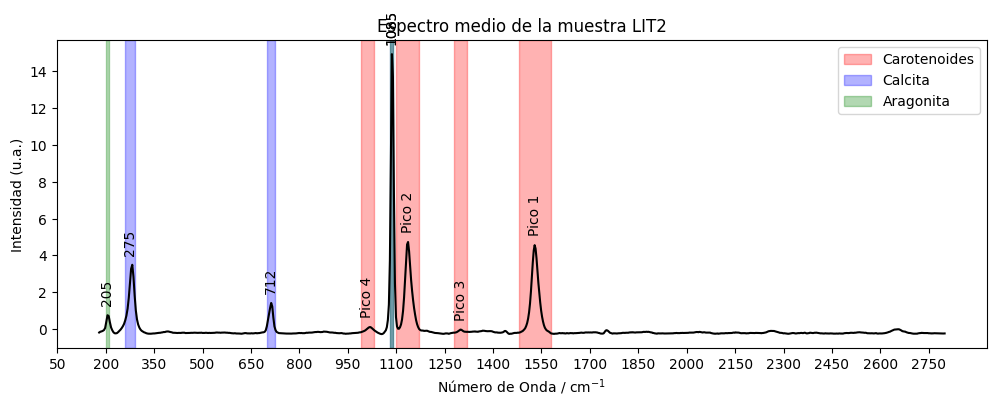

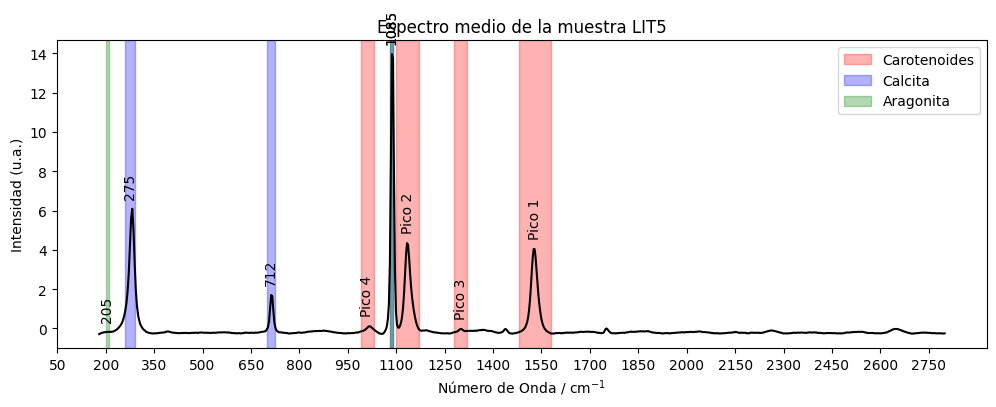

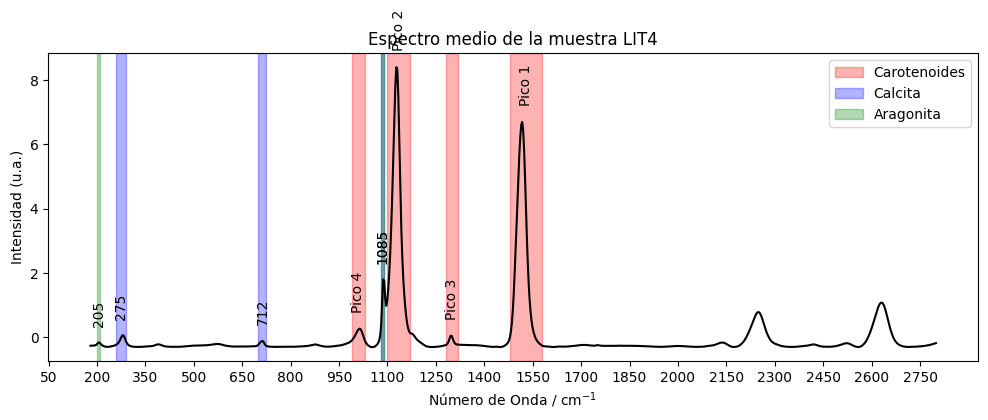

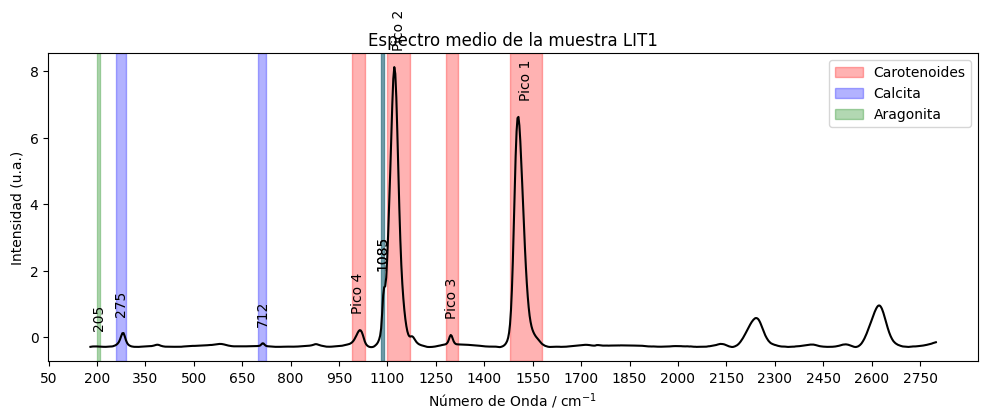

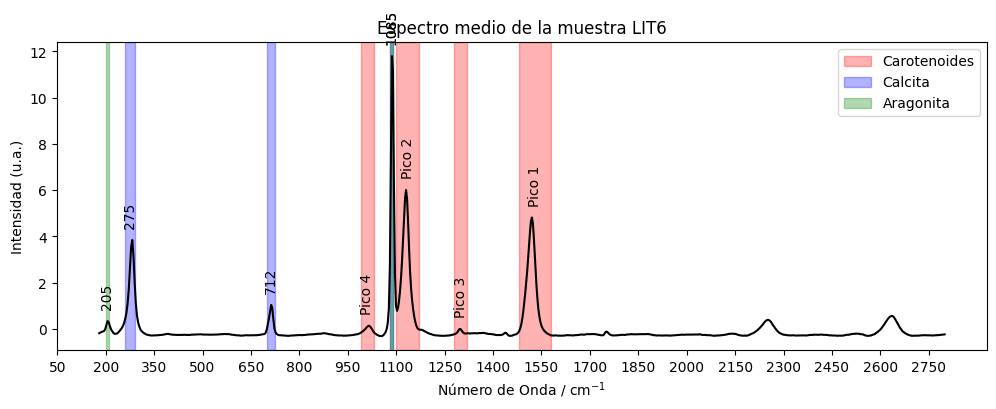

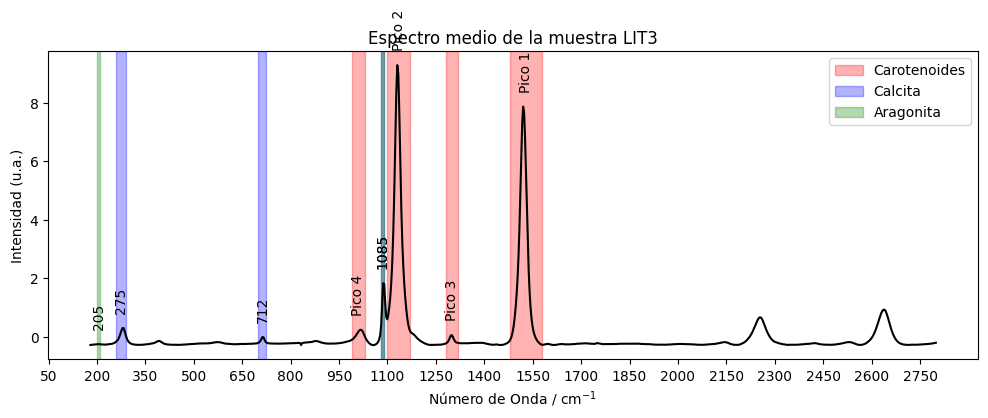

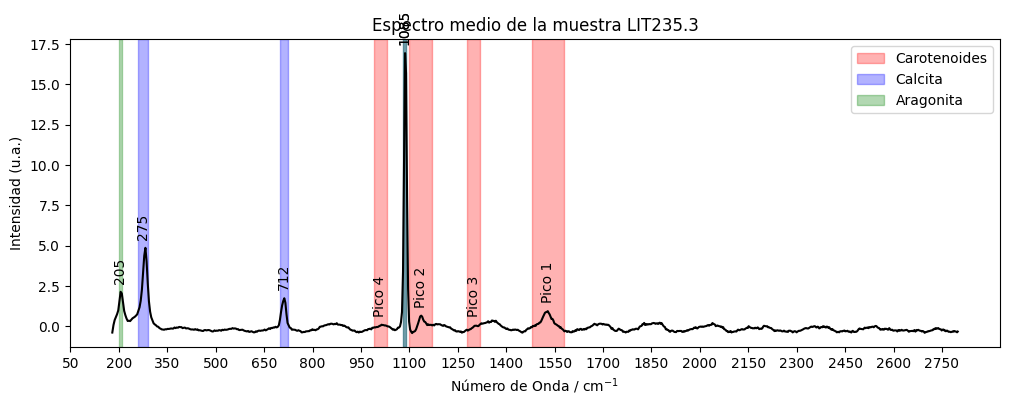

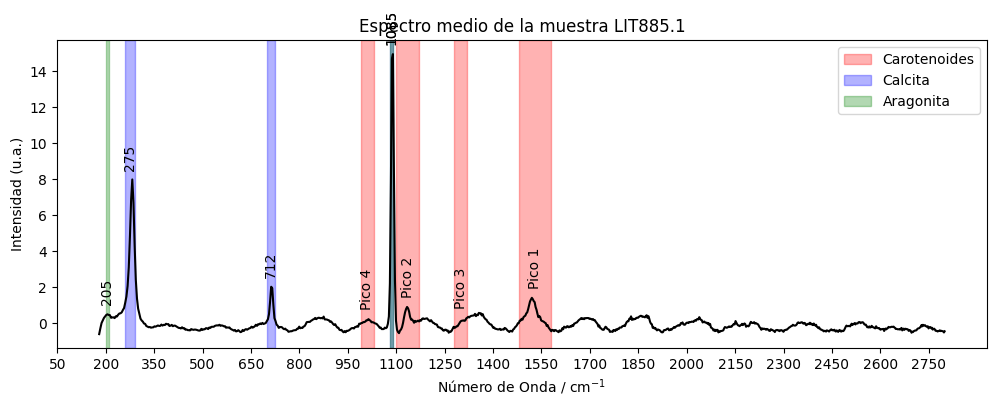

In [48]:
import matplotlib.patches as mpatches
def avg_spectrum (data,
                  muestras):
  #data = pd.concat(dataframes, axis=0)
  #data = create_df(csv_files, path)

  plt.figure(figsize=(12, 4))

  for i, muestra in enumerate(muestras):
    data_muestra = data[data.index.get_level_values('Muestra') == f'{muestra}']
    wavenumber = data_muestra.columns.get_level_values(0).astype(float)
    # Calculamos las intensidades medias para cada numero de onda
    mean_intensity = data_muestra.mean(axis=0)


    # Representa el espectro medio con el color correspondiente
    plt.plot(wavenumber, mean_intensity, label=f'{muestra}', color = 'black')


    # Define the x ranges
    # x_ranges_polimeros = [[1450, 1680], [1070, 1210], [1285,1315]]
    x_ranges_caro = [[1480,1580],[1100,1170], [1280,1320],[990,1030], [2210,2280], [2600,2670]]
    x_ranges_calcita = [[1080,1090],  [260,290], [700,725]]
    x_ranges_aragonito  = [[200,210], [1080,1090]]
    # Plot the areas

    # Nombres de los picos
    peak_names_caro = ['Pico 1', 'Pico 2', 'Pico 3', 'Pico 4']
    peak_names_calcita = ['Pico 5', 'Pico 6', 'Pico 7']
    peak_names_aragonito = ['Pico 8', 'Pico 9']

    # Añade las áreas y los nombres de los picos
    for x_range, peak_name in zip(x_ranges_caro, peak_names_caro):
            plt.axvspan(x_range[0], x_range[1], alpha=0.3, color='red')
            peak_pos = (x_range[0] + x_range[1]) / 2
            peak_height = mean_intensity[(wavenumber >= x_range[0]) & (wavenumber <= x_range[1])].max()
            plt.text(peak_pos , peak_height +0.5, peak_name, color='black', ha='center', va='bottom', rotation=90)

    for x_range, peak_name in zip(x_ranges_calcita, peak_names_calcita):
            plt.axvspan(x_range[0], x_range[1], alpha=0.3, color='blue')
            peak_pos = (x_range[0] + x_range[1]) / 2
            peak_height = mean_intensity[(wavenumber >= x_range[0]) & (wavenumber <= x_range[1])].max()
            plt.text(peak_pos , peak_height + 0.5, round(peak_pos), color='black', ha='center', va='bottom', rotation = 90)

    for x_range, peak_name in zip(x_ranges_aragonito, peak_names_aragonito):
            plt.axvspan(x_range[0], x_range[1], alpha=0.3, color='green')
            peak_pos = (x_range[0] + x_range[1]) / 2
            peak_height = mean_intensity[(wavenumber >= x_range[0]) & (wavenumber <= x_range[1])].max()
            plt.text(peak_pos , peak_height + 0.5, round(peak_pos) , color='black', ha='center', va='bottom', rotation = 90)



  # plt.axvspan(1080,1090, alpha=0.2, color='blue')

  # Define the legend labels and colors
  legend_labels = ['Carotenoides', 'Calcita', 'Aragonita']
  legend_colors = ['red', 'blue', 'green']
  

  # Modify the alpha value of the legend colors
  legend_colors_alpha = [color + '0.2' for color in legend_colors]

  # Create the legend patches with modified alpha values
 # Create the legend patches without modified alpha values
  legend_patches = [mpatches.Patch(color=color, label=label, alpha=0.3) for color, label in zip(legend_colors, legend_labels)]

# Add the legend to the plot
  plt.legend(handles=legend_patches)

  plt.title(f'Espectro medio de la muestra {muestra}')
  # Add the legend to the plot
  plt.legend(handles=legend_patches)
  # Etiquetas y título para el gráfico
  plt.xlabel("Raman Shi / cm$^{-1}$ ")
  plt.ylabel('Intensidad (u.a.)')
  plt.xticks(np.arange(50, max(wavenumber)+1, 150), rotation = 0)
  

  plt.show()

print('Espectros medios para las muestras normalizados con SNV')
muestras_ordenadas_2 = ['LIT2','LIT5','LIT4','LIT1','LIT6','LIT3','LIT235.3','LIT885.1']
for i in muestras_ordenadas_2:
  avg_spectrum(data_sonda_2024_Matlab_snv, [i])


Espectros medios para las muestras normalizados con SNV


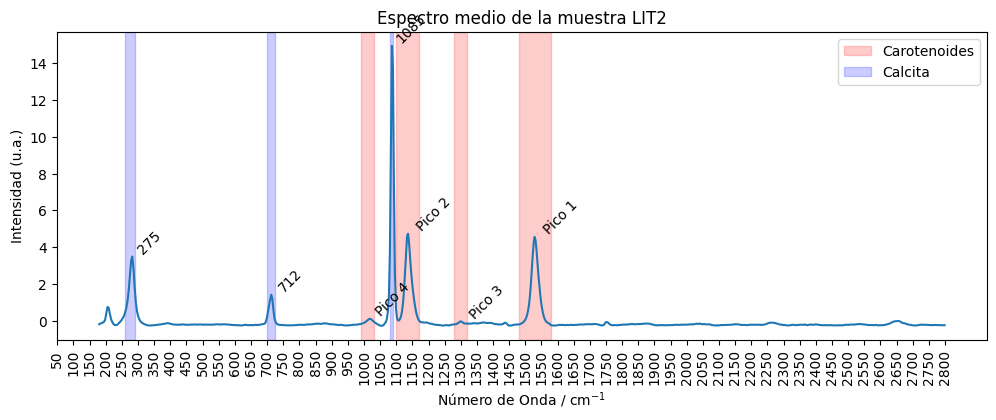

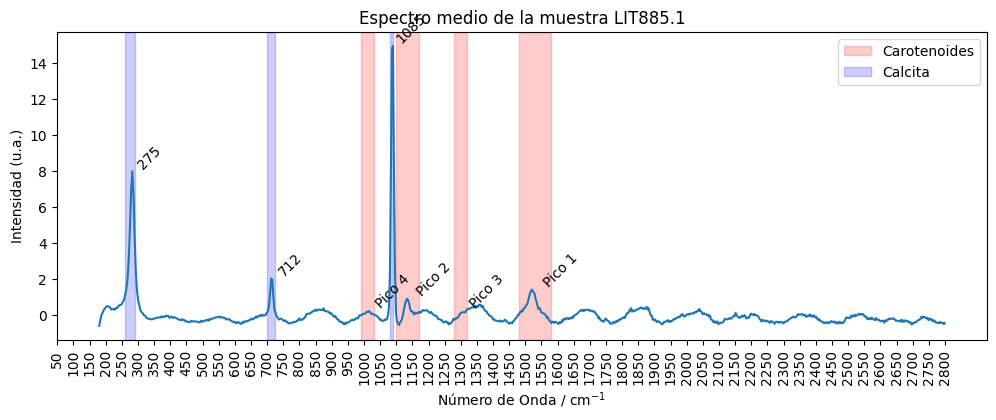

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

def avg_spectrum_pico(data, muestras):
    plt.figure(figsize=(12, 4))

    for i, muestra in enumerate(muestras):
        data_muestra = data[data.index.get_level_values('Muestra') == f'{muestra}']
        wavenumber = data_muestra.columns.get_level_values(0).astype(float)
        mean_intensity = data_muestra.mean(axis=0)

        # Representa el espectro medio con el color correspondiente
        plt.plot(wavenumber, mean_intensity, label=f'{muestra}')

        # Define las áreas de los picos
        x_ranges_caro = [[1480,1580],[1100,1170], [1280,1320],[990,1030]]
        x_ranges_calcita = [[1080,1090], [260,290], [700,725]]

        # Nombres de los picos
        peak_names_caro = ['Pico 1', 'Pico 2', 'Pico 3', 'Pico 4']
        peak_names_calcita = ['Pico 5', 'Pico 6', 'Pico 7']

        # Añade las áreas y los nombres de los picos
        for x_range, peak_name in zip(x_ranges_caro, peak_names_caro):
            plt.axvspan(x_range[0], x_range[1], alpha=0.2, color='red')
            peak_pos = (x_range[0] + x_range[1]) / 2
            peak_height = mean_intensity[(wavenumber >= x_range[0]) & (wavenumber <= x_range[1])].max()
            plt.text(peak_pos +80 , peak_height - 0.01, peak_name, color='black', ha='center', va='bottom', rotation=45)

        for x_range, peak_name in zip(x_ranges_calcita, peak_names_calcita):
            plt.axvspan(x_range[0], x_range[1], alpha=0.2, color='blue')
            peak_pos = (x_range[0] + x_range[1]) / 2
            peak_height = mean_intensity[(wavenumber >= x_range[0]) & (wavenumber <= x_range[1])].max()
            plt.text(peak_pos + 60, peak_height - 0.01, round(peak_pos), color='black', ha='center', va='bottom', rotation = 45)

    # Define las etiquetas y colores de la leyenda
    legend_labels = ['Carotenoides', 'Calcita']
    legend_colors = ['red', 'blue']

    # Crea los parches de la leyenda
    legend_patches = [mpatches.Patch(color=color, label=label, alpha=0.2) for color, label in zip(legend_colors, legend_labels)]

    # Añade la leyenda al gráfico
    plt.legend(handles=legend_patches)

    plt.title(f'Espectro medio de la muestra {muestra}')
    # Etiquetas y título para el gráfico
    plt.xlabel("Número de Onda / cm$^{-1}$ ")
    plt.ylabel('Intensidad (u.a.)')
    plt.xticks(np.arange(50, max(wavenumber) + 1, 50), rotation=90)

    plt.show()


print('Espectros medios para las muestras normalizados con SNV')
muestras_ordenadas_2 = ['LIT2','LIT885.1']
for i in muestras_ordenadas_2:
  avg_spectrum_pico(data_sonda_2024_Matlab_snv, [i])

1292 banda de polyene chain
The spectrum of the recent craniiform, Novocrania anomala (Fig. 6),
is characteristic of the presence of a carotenoid pigment revealed by
the two main bands at 1124 and 1510 cm−1
, which are due to C\\C
stretching (ν2) and in-phase C_C (ν1) vibrations of the polyene chain,
respectively, and two weaker bands at 1009 (ν4) and 1292 cm−1 (ν3)
due to in-plane rocking modes of CH3 groups attached to the polyene
chain and coupled with C\\C bonds as observed in β-carotene, for example [29,36,37].

D. Gaspard et al. / Spectrochimica Acta Part A: Molecular and Biomolecular Spectroscopy 208 (2019) 73–84

Calcita presence of calcite with characteristic. Los del inicio son calcita y el de 700
bands at around 152–155, 280–285, 710–715 and 1085 cm−1 as the
main band and weaker bands around 1436 and 1748 cm−1
), the mineral of which is predominantly calcium phosphate [33], characterized by a specific main
band at around 963 cm−1 (Fig. 11) corresponding to the ν1 P\\O vibration of the phosphate group present in a crystalline network [34].

Melanina:

he Raman spectrum obtained (Fig. 7) evokes a melanin spectrum, which is very similar to amorphous carbon and well-known broad
D and G bands around 1400 cm−1 and 1590 cm−1

## Muestras amarillas


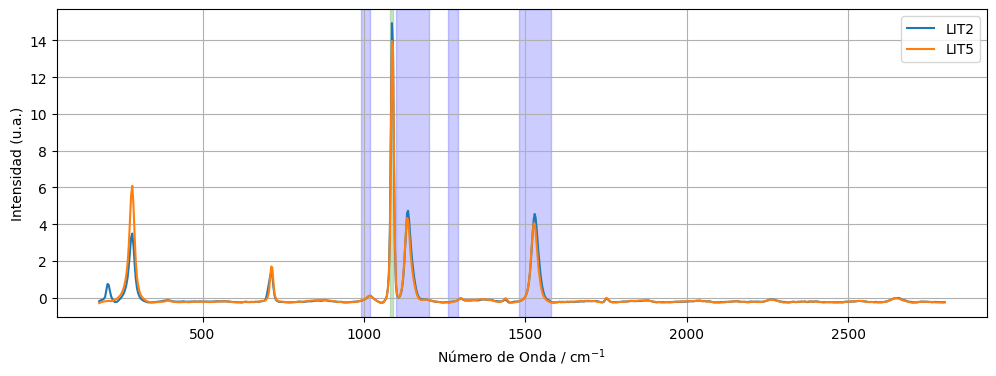

In [48]:
def avg_spectrum (data,
                  muestras 
                  ):
  #data = pd.concat(dataframes, axis=0)
  #data = create_df(csv_files, path)

  plt.figure(figsize=(12, 4))

  for i, muestra in enumerate(muestras):
    data_muestra = data[data.index.get_level_values('Muestra') == f'{muestra}']
    wavenumber = data_muestra.columns.get_level_values(0).astype(float)
    # Calculamos las intensidades medias para cada numero de onda
    mean_intensity = data_muestra.mean(axis=0)


    # Representa el espectro medio con el color correspondiente
    plt.plot(wavenumber, mean_intensity, label=f'{muestra}')
  
  x_ranges_caro = [[1480,1580],[1100,1200], [1260,1290],[990,1018]]

    # Plot the areas
    # for x_range in x_ranges_polimeros:
    #   plt.axvspan(x_range[0], x_range[1], alpha=0.2, color='red')
  for x_range in x_ranges_caro:
      plt.axvspan(x_range[0], x_range[1], alpha=0.2, color='blue')

  plt.axvspan(1080,1090, alpha=0.2, color='green')

  # Define the legend labels and colors
  legend_labels = ['Carotenoides', 'Calcita']
  legend_colors = ['blue',  'green']
  

  # Modify the alpha value of the legend colors
  legend_colors_alpha = [color + '0.2' for color in legend_colors]

  # Create the legend patches with modified alpha values
 # Create the legend patches without modified alpha values
  legend_patches = [mpatches.Patch(color=color, label=label, alpha=0.2) for color, label in zip(legend_colors, legend_labels)]

# Add the legend to the plot
  plt.legend(handles=legend_patches)


  # Etiquetas y título para el gráfico
  plt.xlabel("Número de Onda / cm$^{-1}$ ")
  plt.ylabel('Intensidad (u.a.)')
  
  plt.legend()
  plt.grid(True)



  plt.show()

avg_spectrum(data_sonda_2024_Matlab_snv, ['LIT2','LIT5']) #,'LIT235.3','LIT885.1'